In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation # animaciones
from IPython.display import HTML

from scipy.sparse import diags, kron, csr_matrix, csc_matrix, identity, eye
from scipy.sparse.linalg import spsolve, norm, inv, eigsh

import time

from scipy.fft import fft, ifft, dct, idct
from scipy.integrate import odeint, solve_ivp

# Importamos scipy
from scipy.interpolate import RegularGridInterpolator as interpol
from scipy.optimize import newton


plt.style.use('bmh')

plt.rcParams['figure.figsize'] = (9, 6)
plt.rcParams['legend.fontsize'] = 14
plt.rcParams["axes.titlesize"] = 20
plt.rcParams["axes.labelsize"] = 16
plt.rcParams["figure.titlesize"] = 20

# Colisiones Kink-Antikink en ecuación $\phi_4$

En el presente jupyter se simulará una colisión de ondas kink-antikink en la ecuación $\phi_4$ dada por
$$
\begin{equation}
\left.
\begin{array}[c]{rll}
 \phi_{tt} - \phi_{xx} - \phi + \phi^3= & 0 & \text{sobre }\Omega=\left(0,T\right]\times\left(-L,L\right)\\
\phi(0,x)= & \phi_K(x+x_0) + \phi_{\bar{K}}(x-x_0)-1 & \text{en }x\in [-L, L]\\
\phi_t(0,x)= & -v\phi'_K(x+x_0) - v\phi'_{\bar{K}}(x-x_0) & \text{en }x\in [-L, L]
\end{array}
\right\} \quad (1)
\end{equation}
$$

Con condiciones de borde periódica o Neumann según lo que se requiera. Los objetivos son:
* Encontrar el mejor método de simulación, es decir, aquel método con menor propagación de errores.
* Obtener la velocidad de salida después de la colisión.
* Obtener los gráficos correspondientes, de forma de replicar los resultados del paper.

## introducción

Los métodos utilizados para simular la ecuación corresponden a diferencias finitas (esquemas explícito e implícito) y métodos espectrales. Es esperable que la presición de la simulación mejor con respecto a cada método usado, donde los esquemas espectrales tengan menor dispersión de error y deseablemente deban ser utilizados en la obtención de las velocidades de salida.

Se definen en primer lugar funciones con las condiciones iniciales del problema:

In [2]:
# Función secante hiperbolica
def sech(x):
    return 1/np.cosh(x)

# Función kink
def phi_k(x, v):
    return np.tanh(x/(np.sqrt(2) * np.sqrt(1-v**2)))

# Derivada kink
def phi_k_t(x, v):
    return sech(x/(np.sqrt(2) * np.sqrt(1-v**2)))**2

# Condición inicial
def phi_0(x, x0, v):
    return phi_k(x+x0, v) - phi_k(x-x0, v)-1

# Condición inicial derivada temporal
def phi_1(x, x0, v):
    return -v/np.sqrt(2*(1-v**2)) * (phi_k_t(x+x0, v) + phi_k_t(x-x0, v))

En todas las simulaciones, se utilizarán $x_0 = 10$, $L = 20$ y tiempo final $T=100$. Este último parámetro podría variar según la velocidad de cálculo computacional de cada esquema.

In [322]:
x0 = 10
xi = -20 #-32
xf = 20 # 32
tf = 150

A modo de testeo, se probarán las velocidades $v \in \{0.35, 0.186, 0.1988, 0.213\}$.

In [323]:
# Velocidades
vs =  [0.19125]#[0.189, 0.19125, 0.2384, 0.35]#np.linspace(0.18, 0.34, 800) #np.arange(0.19, 0.2, 0.001) #

## Diferencias finitas: Esquema explícito

Para $h>0$ y $dt = h/2$ (se debe cumplir la condición CFL) se obtienen una grilla espacial de $N$ puntos y una temporal de $N_T = T/dt$ puntos, además del siguiente problema discretizado centralizado en tiempo y espacio:

$$
\frac{\phi_j^{n+1} - 2\phi_j^n + \phi_j^{n-1}}{dt^2} - \frac{\phi_{j+1}^n - 2\phi_j^n + \phi_{j-1}^n}{h^2} + f(\phi_j^n) = 0
$$

donde $f(\phi) = -\phi + \phi^3$. Definimos $\lambda = \frac{dt}{h}$ y despejando $\phi_j^{n+1}$ se obtiene un esquema explícito para la ecuación $\phi_4$:

$$
\phi_j^{n+1} = 2\left (1-\lambda^2\right )\phi_j^n - \phi_j^{n-1} + \lambda^2\phi_{j+1}^n + \lambda^2\phi_{j-1}^n - dt^2f(\phi_j^n)
$$
Con condiciones iniciales:

* $\phi_j^0 = \phi_K(x_j+x_0) + \phi_{\bar{K}}(x_j-x_0)-1$
* $\phi_j^1 = \left(-v\phi'_K(x_j+x_0) - v\phi'_{\bar{K}}(x_j-x_0)\right) dt + \phi_j^0$

y con condiciones de borde periódicas (que será resuelto utilizando el método ``np.roll``). Este esquema se implementa a continuación en la función ``solve_explicit``.

In [324]:
def solve_explicit(x0, xi, xf, h, dt, tf, v):
    
    # Puntos de las grillas
    Nx = int((xf - xi)/h)
    Nt = int(tf/dt)

    # Crea grillas
    x = np.arange(xi,xf, h)
    t = np.arange(0, tf, dt)

    # Vector para guardar solución
    phi = np.zeros((Nt, Nx))

    # Setea condiciones iniciales
    phi[0] = phi_0(x, x0, v)
    phi[1] = phi_1(x, x0, v) * dt + phi[0]
    
    # Lambda
    l = dt/h
    
    # Itera puntos temporales
    for n in range(2, Nt):
        
        # Instante anterior y paso actual
        phi_j_last = phi[n-2]
        phi_j = phi[n-1]

        # Condiciones periódicas
        
        # Vecino derecha
        phi_j_der = np.roll(phi_j, shift=1)

        # Vecino izquierda
        phi_j_izq = np.roll(phi_j, shift=-1)

        # Solución instante actual
        phi_j_sgte =  2 * (1 - l**2) * phi_j - phi_j_last + l**2 * (phi_j_der + phi_j_izq) + dt**2 * (phi_j - phi_j**3)

        # Guarda solución
        phi[n] = phi_j_sgte
    
    # Retorna grillas y solución
    return x, t, phi

Se simulará el modelo para las velocidades antes mencionadas y se observará el comportamiento de la solución en cada una. Además, se utilizará $h=0.1$.

In [325]:
# Parámetros de discretización
h = 0.01
dt = 0.009 #h/2

phis = []

for v in vs:
    x, t, phi = solve_explicit(x0, xi, xf, h, dt, tf, v)
    phis += [phi]

In [326]:
def get_plot_phi(x, t, phi, v, doc_name):
    fig, ax = plt.subplots(1, 1)
    
    ax.set_title(r"Solución $\phi^4$ para $v=${}".format(round(v, 4)))
    im = ax.pcolorfast(t, x, phi.T)
    
    fig.colorbar(im)
    ax.set_xlabel("t")
    ax.set_ylabel("x")
    plt.grid()
    plt.savefig(doc_name)
    plt.show()

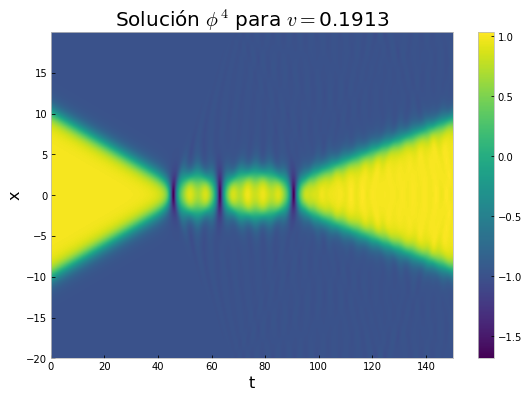

In [328]:
# Directorio gifs esquema explicito
path_exp = "Charts/Explicit"

for i in range(len(phis)):
    get_plot_phi(x, t, phis[i], vs[i], path_exp+"/calor_v_{}".format(5))

In [329]:
def energy(theta, phi, n, dt, dx):
    phi_t = ((phi[n+1] - phi[n])/dt)**2
    phi_x = np.diff(phi[n+1])*np.diff(phi[n])/(dx**2) #(np.diff(phi[n])/dx)**2
    theta_phi_x = theta * (((np.diff(phi[n+1]) - np.diff(phi[n]))/dx)**2)
    extra = 1/2 * (phi[n]**2 - 1)**2
    output = np.sum(phi_t[:-1] + phi_x + theta_phi_x + extra[:-1])/2
    
    return output

In [330]:
energies_exp = []

h = 0.01
dt = 0.009

for phi in phis:
    energy_ = np.zeros(len(phi)-1)
    for n in range(len(phi)-1):
        E = energy(0., phi, n, dt, h)
        energy_[n] = E
    energies_exp += [energy_]

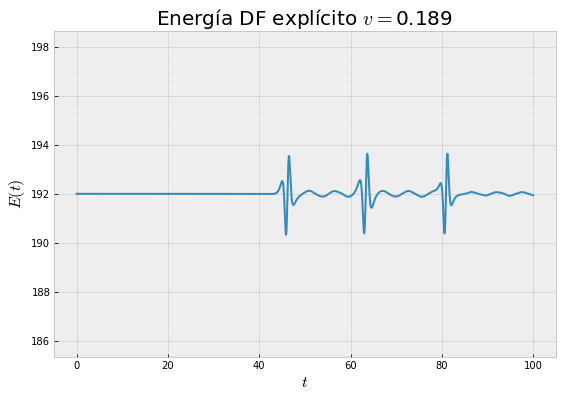

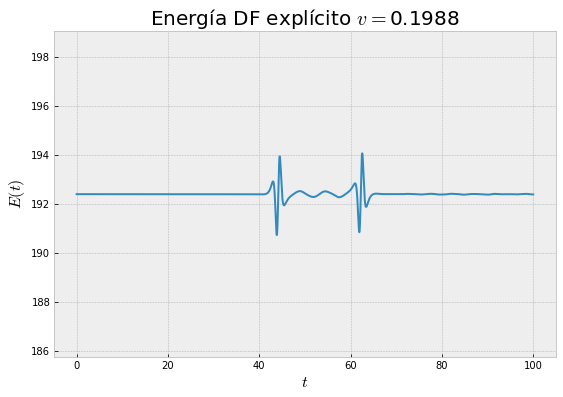

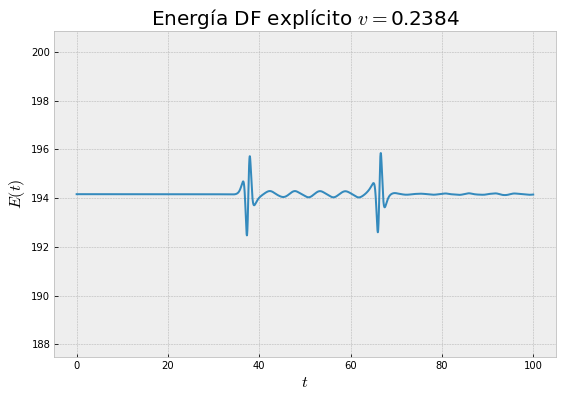

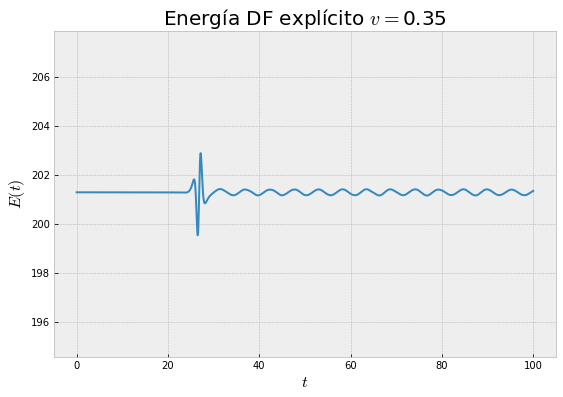

In [286]:

for i in range(len(vs)):
    plt.plot(t[:-2], energies_exp[i])
    plt.title("Energía DF explícito $v=${}".format(vs[i]))
    plt.xlabel(r"$t$")
    plt.ylabel(r"$E(t)$")
    plt.ylim(np.min(energies_exp[i])-5, np.max(energies_exp[i])+5)
    
    plt.savefig(path_exp + "/energia_{}.png".format(5))
    plt.show()

Experimentando con distintas tamaños de grillas espaciales, se determinó que a partir de $h=0.1$ no ocurren cambios notorios en la solución. Por otro lado, se comprobó que $dt=\frac{h}{2}$ resulta ser también un buen espaciado temporal.

Como añadido extra, se define una función que crea animaciones de la solución. Esto ayudará a obtener las velocidades de salida de manera más ilustrativa.

In [9]:
def animar_soluciones(x, phi, v, dt, tf, doc_name, path):
    
    # Cantidad de frames
    Nt = int(tf/dt)

    # Crea figura
    fig, ax = plt.subplots()
        
    # Grafica instante inicial
    line1, = ax.plot(x, phi[0])
    #line1, = ax.plot(x, (phi[0] + 1)*np.cosh(x))
    #line2, = ax.plot(x, -1 + sech(x))
    ax.set_ylim(-2, 2)
    ax.set_title("Solución $\phi^4$ para $v=${}".format(v))

    # Funcion para animar
    def animate(i):
        
        # Actualiza grafico en cada instante temporal
        line1.set_data(x, phi[i])

        return line1,

    # Animación
    ani = animation.FuncAnimation(fig, animate, frames=np.arange(0, Nt, 10), interval=50, blit=True)

    ani.save(path + "/" + doc_name)
    return ani

MovieWriter ffmpeg unavailable; using Pillow instead.
MovieWriter ffmpeg unavailable; using Pillow instead.
MovieWriter ffmpeg unavailable; using Pillow instead.
MovieWriter ffmpeg unavailable; using Pillow instead.
MovieWriter ffmpeg unavailable; using Pillow instead.
MovieWriter ffmpeg unavailable; using Pillow instead.
MovieWriter ffmpeg unavailable; using Pillow instead.
MovieWriter ffmpeg unavailable; using Pillow instead.
MovieWriter ffmpeg unavailable; using Pillow instead.
MovieWriter ffmpeg unavailable; using Pillow instead.
MovieWriter ffmpeg unavailable; using Pillow instead.


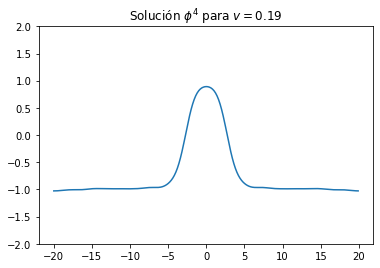

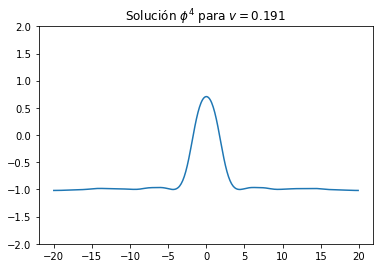

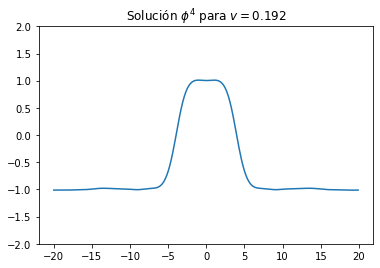

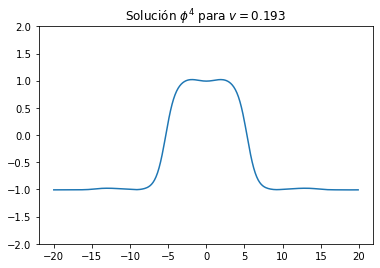

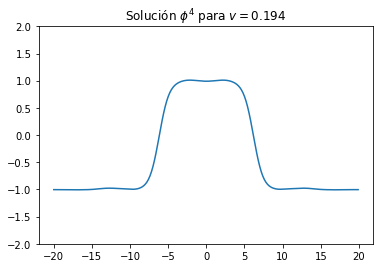

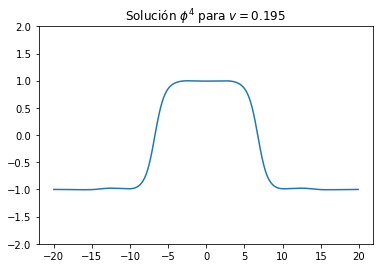

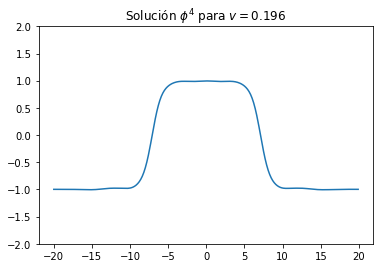

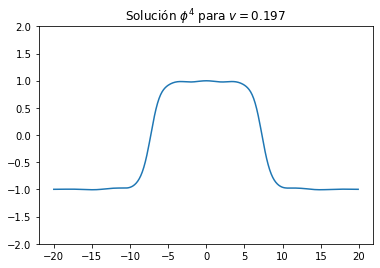

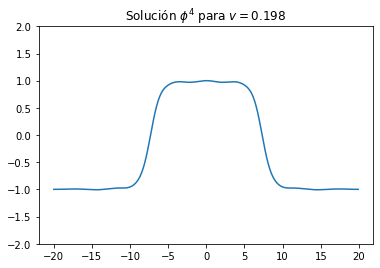

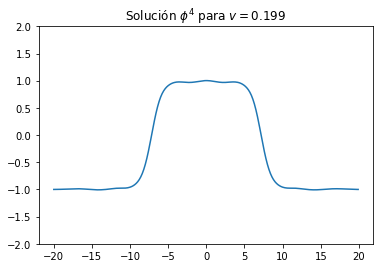

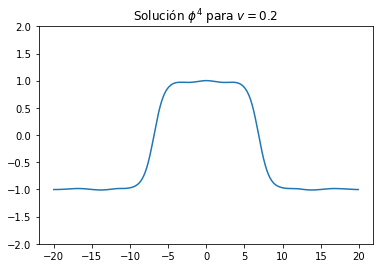

In [10]:
for i in range(len(phis)):
    animar_soluciones(x, phis[i], vs[i], dt, tf, "Exp_v_{}.gif".format(i), path_exp)
    
# Deprecado
#animar_soluciones(x, phi_second, Nt, "Caso_2_phi_4.gif", path)
#animar_soluciones(x, phi_third, Nt, "Caso_3_phi_4.gif", path)

#animar_soluciones(x, phi_second, Nt, "Caso_2_phi_4_sech.gif", path)

## Esquema implícito

Dada la dificultad al invertir matrices en problemas con condiciones de border periódicas, se utilizan condiciones neumann nulas en los bordes.

In [310]:
def f(u):
    return -u + u**3

def Ah(l, N):
    
    e = np.ones(N)*(1 + l ** 2)
    #e[0] = e[-1] = 1 + (l**2)/2 # En los extremos vale 1+lambda^2/2
    
    f = np.ones(N-1)*(l**2)/2
    
     # Arreglo con las diagonales
    k = np.array([-f,e,-f], dtype= object) 
    offset = [-1,0,1] #Posiciones de las diagonales
    
    A = diags(k, offset, format="csc")
    
    A = A.tolil()
    
    A[0, -1] = -(l**2) / 2 # Agregan periodicidad
    A[-1, 0] = -(l**2) / 2
        
    return A

def bn(u, dt):
    return 2 * u - f(u) * dt**2

def solve_implicit(x0, xi, xf, h, dt, tf, v, return_bounces=False):
    
    # Puntos de cada grilla
    Nx = int((xf - xi)/h)
    Nt = int(tf/dt)
    
    # Grillas
    x = np.linspace(xi,xf, Nx)
    t = np.linspace(0, tf, Nt)
    
    # Lambda
    l = dt / h

    u = np.zeros((Nt, Nx))

    # Setea condiciones iniciales
    u[0] = phi_0(x, x0, v)
    u[1] = phi_1(x, x0, v) * dt + u[0]
    
    # Obtiene matriz A
    A = Ah(l, Nx)
    A = A.tocsc()
    
    # Guarda n bounces
    n_bounces = []
    
    # Recorre puntos temporales
    for n in range(1, Nt-1):
        
        # Paso actual y anterior
        un = u[n]
        un_last = u[n-1]
        
        # Vector b
        b = bn(un, dt)
        
        # Invierte matriz
        un_sig = spsolve(A, b)
        
        # Actualiza paso siguiente
        u[n+1] = un_sig - un_last # Habiamos resuelto para u_{n+1} + u_{n-1}
        
        if np.min(u[n+1]) < -1.5:
            n_bounces += [n+1]
    
    if return_bounces:
        return x, t, u, n_bounces
    
    # Retorna grillas y solucion
    return x, t, u

### Simulación

In [311]:
# Parámetros de discretización
h = 0.01
dt = 0.01

# Guarda soluciones y grillas espaciales
us = []
xs = []

# Guarda lista de veces que la solución fue menor a -1.5
bounces = np.full(len(vs), fill_value=None)

for i in range(len(vs)):
    v = vs[i]
    x, t, u, bounce = solve_implicit(x0, xi, xf, h, dt, tf, v, return_bounces=True)
    us += [u]
    xs += [x]
    bounces[i] = bounce
    

MovieWriter ffmpeg unavailable; using Pillow instead.
MovieWriter ffmpeg unavailable; using Pillow instead.
MovieWriter ffmpeg unavailable; using Pillow instead.
MovieWriter ffmpeg unavailable; using Pillow instead.
MovieWriter ffmpeg unavailable; using Pillow instead.
MovieWriter ffmpeg unavailable; using Pillow instead.
MovieWriter ffmpeg unavailable; using Pillow instead.
MovieWriter ffmpeg unavailable; using Pillow instead.
MovieWriter ffmpeg unavailable; using Pillow instead.
MovieWriter ffmpeg unavailable; using Pillow instead.
MovieWriter ffmpeg unavailable; using Pillow instead.


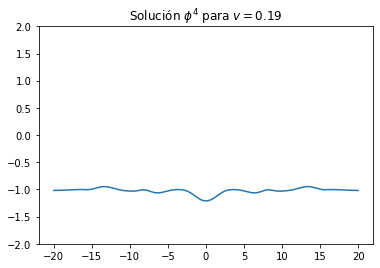

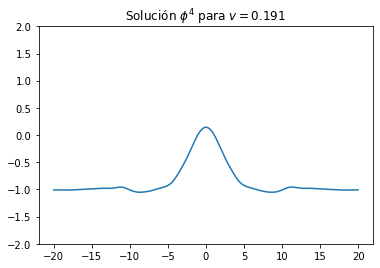

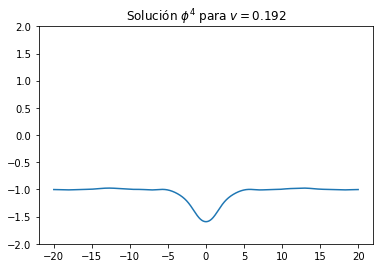

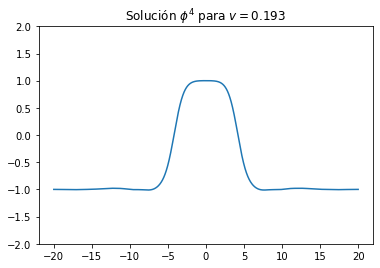

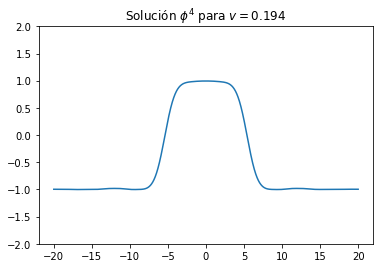

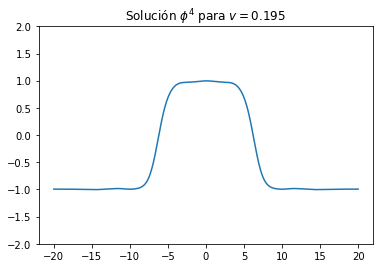

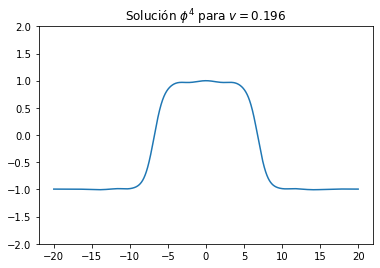

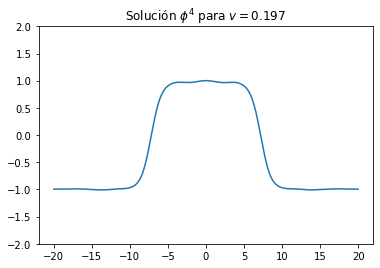

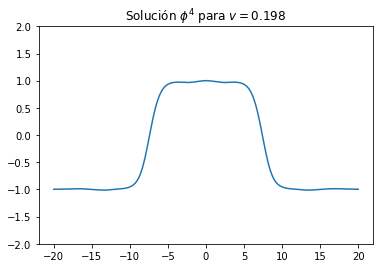

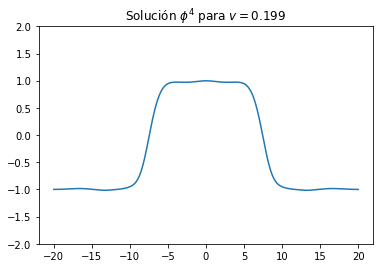

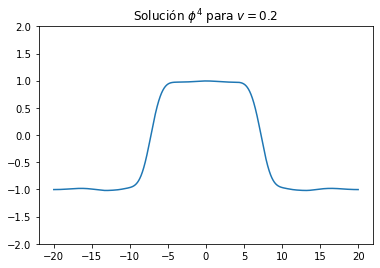

In [13]:
# Directorio gifs esquema implicito
path_imp = "Charts/Implicit"

# Obtiene animaciones para cada velocidad
for i in range(len(us)):
    animar_soluciones(xs[i], us[i], vs[i], dt, tf, "Imp_v_{}.gif".format(i), path_imp)

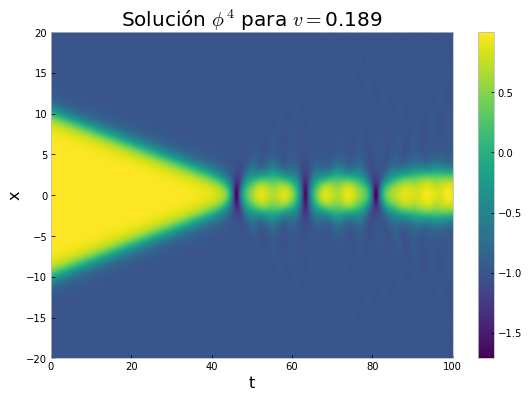

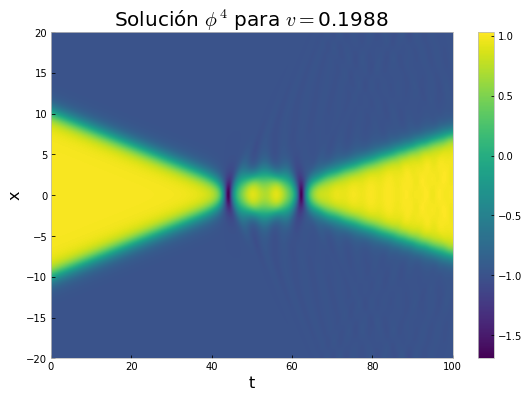

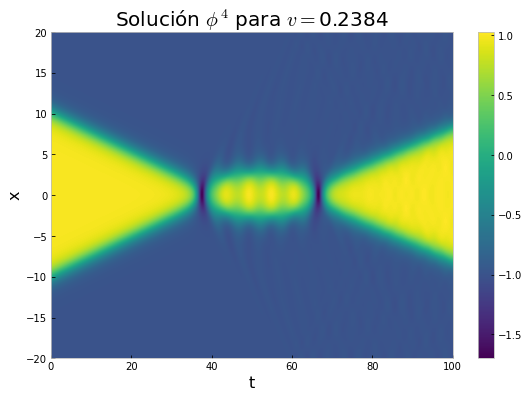

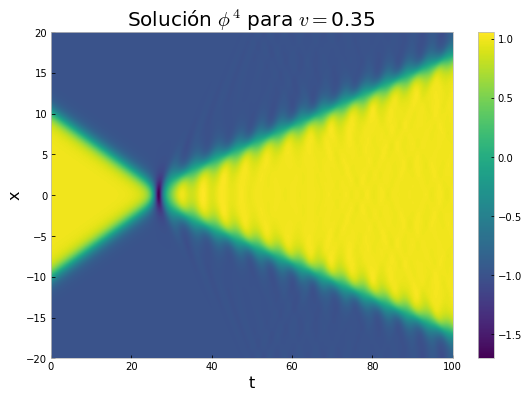

In [314]:
path_imp = "Charts/Implicit"

for i in range(len(phis)):
    get_plot_phi(x, t, us[i], vs[i], path_imp+"/calor_v_{}".format(i))

In [315]:
energies_imp = []
h = 0.01
dt = 0.01

for phi in us:
    energy_ = np.zeros(len(phi)-1)
    for n in range(len(phi)-1):
        E = energy(1/2, phi, n, dt, h)
        energy_[n] = E
    energies_imp += [energy_]

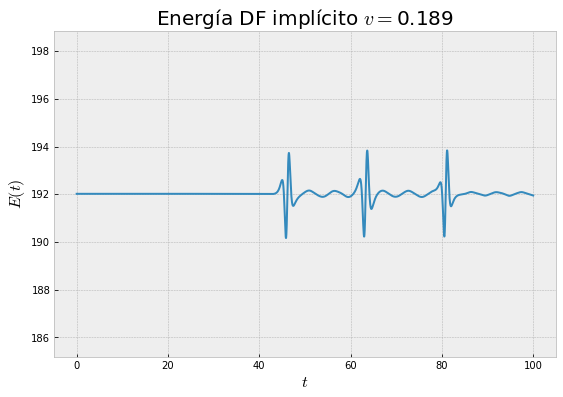

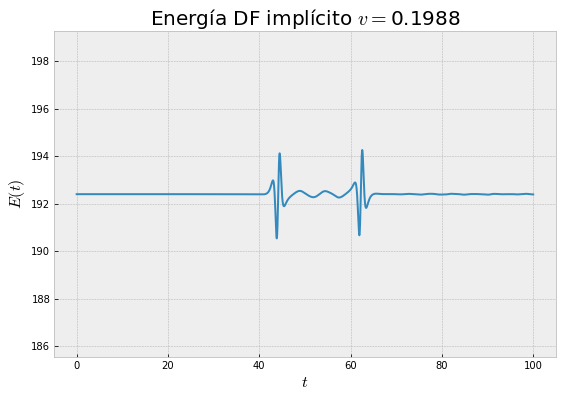

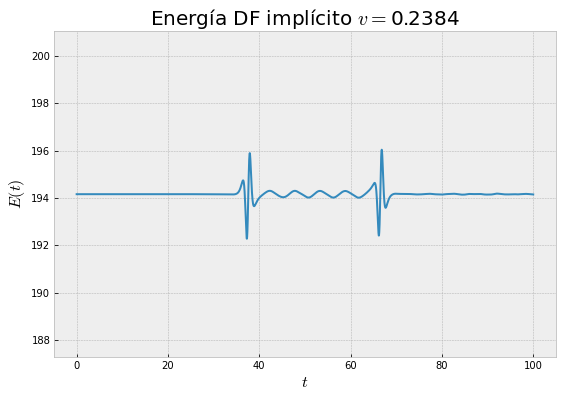

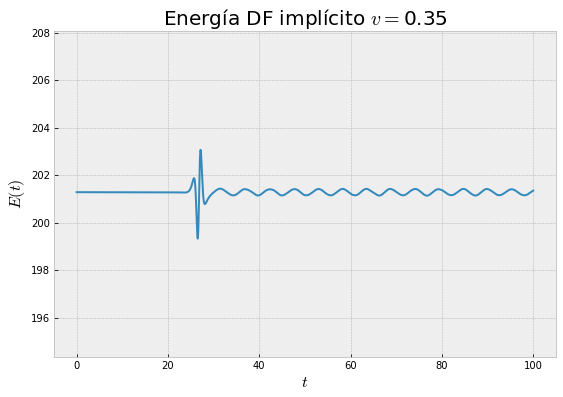

In [317]:

for i in range(len(vs)):
    plt.plot(t[:-1], energies_imp[i])
    plt.title("Energía DF implícito $v=${}".format(vs[i]))
    plt.xlabel(r"$t$")
    plt.ylabel(r"$E(t)$")
    plt.ylim(np.min(energies_imp[i])-5, np.max(energies_imp[i])+5)
    
    plt.savefig(path_imp + "/energia_{}.png".format(i))
    plt.show()

## Método espectral

Se utilizará el método de colocación, que corresponde a un método pseudoespectral y donde la solución se aproxima evaluando en puntos de colocación estratégicos, o mejor dicho, una malla discreta de puntos. Primeramente se usarán las frecuencias de sampleos de la transformada de Fourier, que se obtienen con el método ``np.fft.fftfreq`` y luego una discretización de malla útil para la transformada del coseno.

La primera sección utilizará una combinación entre las frecuencias de Fourier y la transformada del coseno. La segunda sección será destinada totalmente a la transformada del coseno, puesto que la condición inicial del problema es par y cuya paridad se preserva en la ecuación.

### Híbrido coseno y frecuencias de Fourier

Para resolver las EDO´s que aparezcan, se utilizará Runge Kutta 4. La implementación incluye un parámetro para retornar los bounces de la solución. Esta variante permite calcular la velocidad de salida de la solución.

In [137]:
def RK4(f, ti, tf, h, X0, args, get_bounces=False):
    """ Función que entrega la aproximación numérica de Runge Kutta 4 
    para la solución al problema X' = f(t,X).

    f: Función f(t,X,args) que es función de lado derecho de la ecuación
    ti: t inicial
    tf: t final
    h: Paso h del método
    X0: Condición inicial
    args: Argumentos a entregar a la función f

    Regresa (t,X) donde t es el intervalo [ti,tf] equiespaciado y X
    la aproximación a la solución mediante método de Runge Kutta de orden 4.
    """
    # Cardinal del equiespaciado del método
    N = int((abs(tf-ti))/h)

    # Arreglo de t
    t = np.linspace(ti, tf, N)
    
    Nx = len(X0)

    # Arreglo para la solución
    X = np.zeros((N, Nx))

    # Condición inicial
    X[0] = X0
    
    # Guarda n bounces
    n_bounces = []

    # Método de Runge Kutta 4
    for i in range(N-1):
        g1 = f(t[i]      , X[i]       , args)
        g2 = f(t[i] + h/2, X[i]+h/2*g1, args)
        g3 = f(t[i] + h/2, X[i]+h/2*g2, args)
        g4 = f(t[i] + h  , X[i]+h*g3  , args)
        X[i+1] = X[i] + h/6*(g1 + 2*g2 + 2*g3 + g4)
        
        
        # Obtiene bounces de la solución
        if get_bounces:
            X_bounces = X[:, :Nx//2]
        
            if np.min(X_bounces[i+1]) < -1.5:
                n_bounces += [i+1]

    if get_bounces:
        return t, X.T, n_bounces
    return (t,X.T)

Definimos los parámetros de discretización:

In [16]:
L = 20
dt = 0.1
tend = 120
x0 = 10
nx = 128

Se define la función ``rhsf`` que retorna la transformada de coseno aplicada a la ecuación $\phi_4$ y evaluada en los puntos de colocación para la transformada de Fourier.

In [17]:
def rhsf(phi, t, L):
    nx = len(phi) #Podria tener error
    n = np.fft.fftfreq(nx) * nx * 2 * np.pi / L
    return idct((2 * np.pi * 1j * n / L)**2 * dct(phi)).real + phi - phi**3

Definimos las derivadas del sistema. Como tenemos dos derivadas en tiempo, se define $z = \phi_t$, obteniendo dos edos por cada valor arrojado en la función ``rhsf``.

In [18]:
def system_derivative(t, y, L):
    total = len(y)
    phi = y[:total//2].copy()
    z = y[total//2:].copy()

    dphi = z
    dz = rhsf(phi, t, L)

    dy = np.append(dphi, dz)

    return dy

Definimos una función que nos arroje la solución con el método mencionado. Recibirá los parámetros antes definidos y retornará la solución deseada.

In [19]:
def solve_fft(L, dt, tend, x0, nx, v):
    dx = L/nx

    # Grilla
    x = np.linspace(-L, L, nx)

    # Condiciones iniciales
    phi0 = phi_0(x, x0, v)
    phi1 = phi_1(x, x0, v)
    y0 = np.append(phi0, phi1)

    t, y, bounces = RK4(system_derivative,0, tend, dt, y0, L, get_bounces=True)
    
    # Rescata la solución que nos interesa
    total = len(y)
    y_sol = y[:total//2]
    y_sol = y_sol.T
    
    return t, x, y_sol, bounces

Obtenemos la solución para varias velocidades de entrada.

In [39]:
# Guarda valores entregados por la solucion
phis = []
xs = []
ts = []
bounces = []

for i in range(len(vs)):
    # Resuelve para varios vs
    t, x, y, bounce = solve_fft(L, dt, tend, x0, nx, vs[i])
    
    phis += [y]
    xs += [x]
    ts += [t]
    bounces += [bounces]


NameError: name 'solve_fft' is not defined

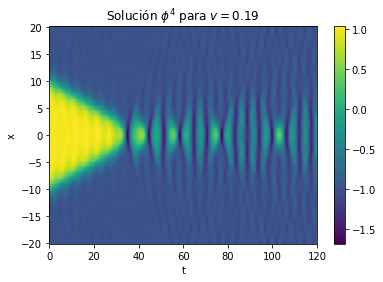

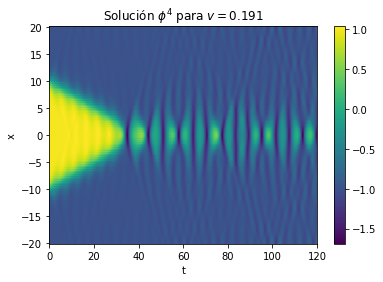

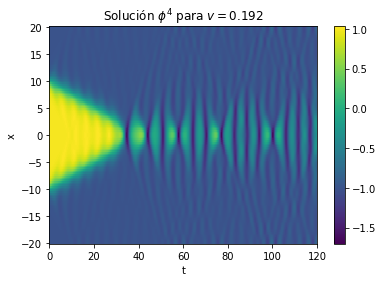

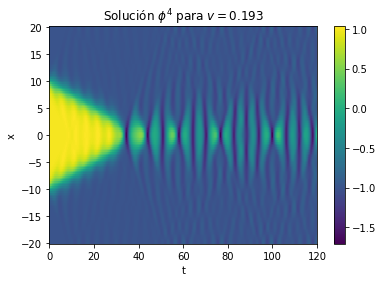

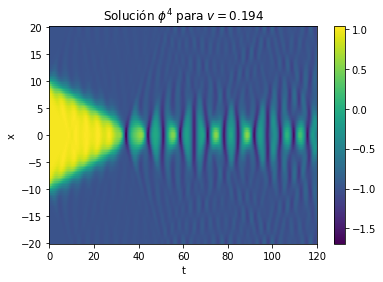

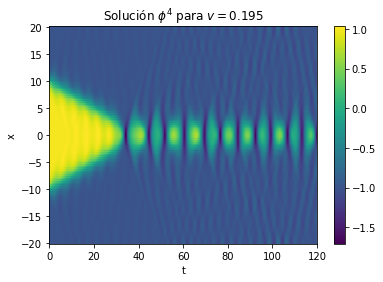

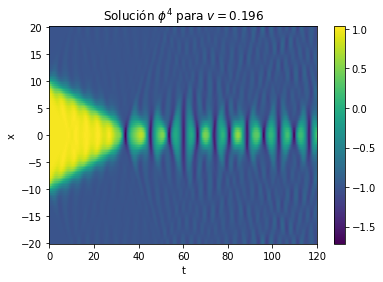

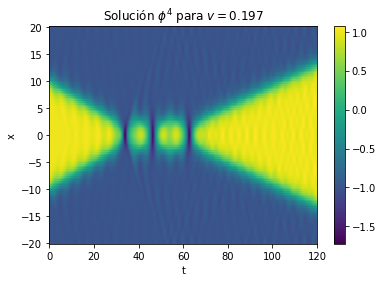

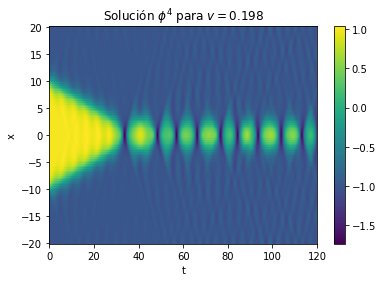

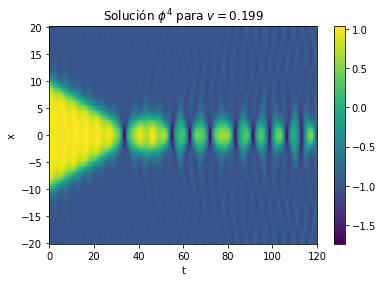

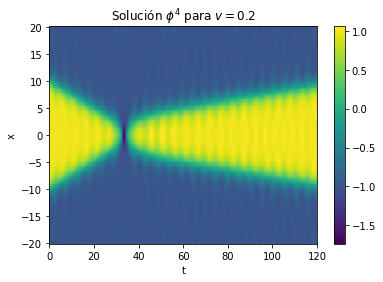

In [21]:
# Obtiene gráficos
path_esp_f = "Charts/Spectral/Fourier"

for i in range(len(phis)):
    get_plot_phi(xs[i], ts[i], phis[i], vs[i], path_esp_f+"/calor_v_{}".format(i))

MovieWriter ffmpeg unavailable; using Pillow instead.
MovieWriter ffmpeg unavailable; using Pillow instead.
MovieWriter ffmpeg unavailable; using Pillow instead.
MovieWriter ffmpeg unavailable; using Pillow instead.
MovieWriter ffmpeg unavailable; using Pillow instead.
MovieWriter ffmpeg unavailable; using Pillow instead.
MovieWriter ffmpeg unavailable; using Pillow instead.
MovieWriter ffmpeg unavailable; using Pillow instead.
MovieWriter ffmpeg unavailable; using Pillow instead.
MovieWriter ffmpeg unavailable; using Pillow instead.
MovieWriter ffmpeg unavailable; using Pillow instead.


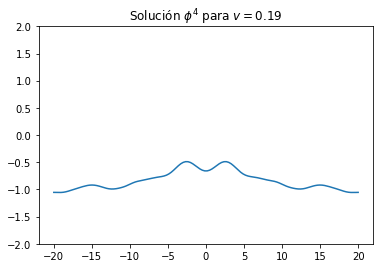

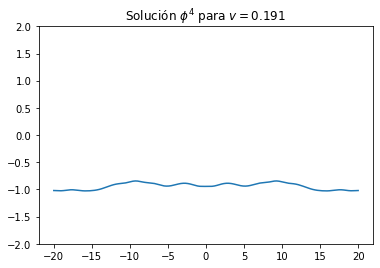

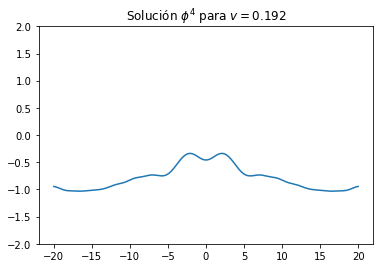

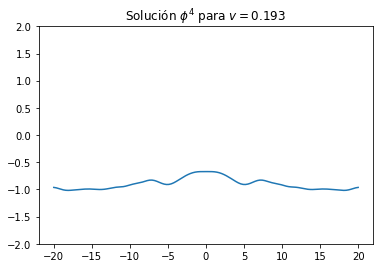

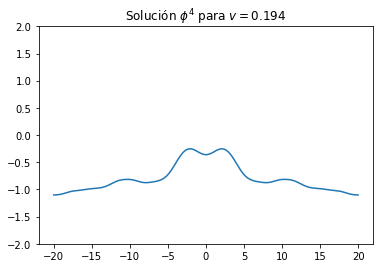

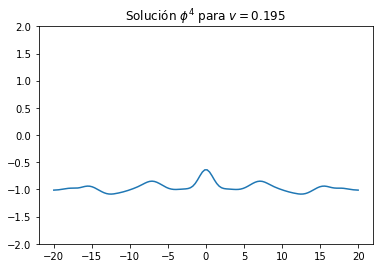

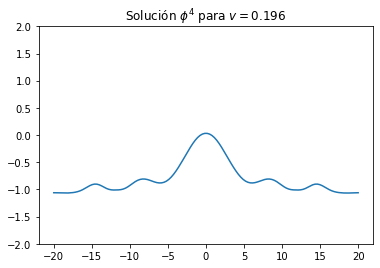

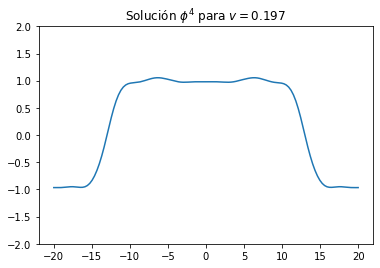

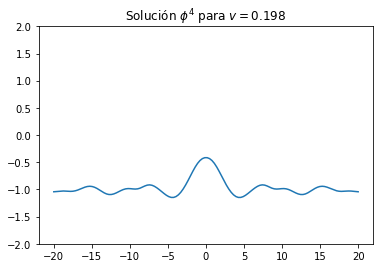

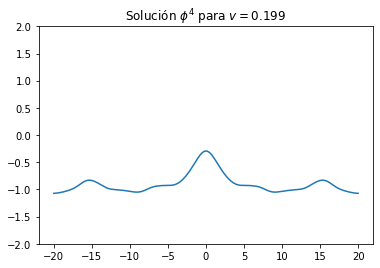

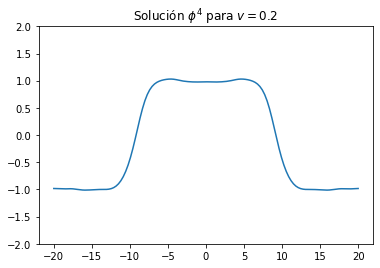

In [22]:
for i in range(len(phis)):
    animar_soluciones(xs[i], phis[i], vs[i], dt, tend, "Esp_f_v_{}.gif".format(i), path_esp_f)

## Transformada de coseno

Dada la incertidumbre del funcionamiento del método anterior, se plantea un nuevo método espectral utilizando solo la transformada del coseno. Se plantean nuevos puntos de colocación acorde al nuevo método (ahora se evaluará en puntos impares). Además, dada la paridad de la solución, solo se utilizarán puntos positivos en la evaluación y la solución final corresponderá a una reflexión de la solución obtenida.

Se definen los parámetros de discretización.

In [169]:
L  = 12.0 # Solo para el método. Cuando se refleja se multiplica por 2
dt = 1/20 #0.1
tend = 110

x0 = 10
nx = 256

La igual que en el método anterior, definimos funciones que evalúa la transformada del coseno en la ecuación $\phi_4$ y en los nuevos puntos de colocación, y otra función con las derivadas del sistema, que servirá para resolver la ecuación usando RK4.

In [173]:
def rhsf_cos(phi, t, L):
    N = len(phi)
    kj = np.array([np.pi*j/(2*L) for j in range(N)])
    output = idct(-(kj**2) * dct(phi)) + phi - phi**3
    return output


def system_derivative_cos(t, y, L):
    total = len(y)
    phi = y[:total//2].copy()
    z = y[total//2:].copy()
    
    dphi = z
    dz = rhsf_cos(phi, t, L)

    dy = np.append(dphi, dz)

    return dy

Finalmente, definimos una función que resuelve según los parámetros entregados.

In [174]:
def solve_dct(L, dt, tend, x0, nx, v):

    dx = L/(nx)
    
    # Puntos de colocación
    xn = np.array([dx*(2*n+1) for n in range(nx)])

    phi0 = phi_0(xn, x0, v)
    phi1 = phi_1(xn, x0, v)

    y0 = np.append(phi0, phi1)
    
    t, y, bounce = RK4(system_derivative_cos,0,tend,dt,y0, L, get_bounces=True)
    
    total = len(y)
    y_sol = y[:total//2]
    
    # Refleja la solución
    y_sol = np.append(np.flip(y_sol, 0).T, y_sol.T, 1)
    
    # Grilla reflejada
    x = np.linspace(-2*L, 2*L, 2*nx)
    
    return t, x, y_sol, bounce

### Simulación

In [175]:
# Guarda valores entregados por la solucion
phis = []
xs = []
ts = []
bounces = []

for i in range(len(vs)):
    # Resuelve para varios vs
    t, x, y, bounce = solve_dct(L, dt, tend, x0, nx, vs[i])
    
    phis += [y]
    xs += [x]
    ts += [t]
    bounces += [bounce]

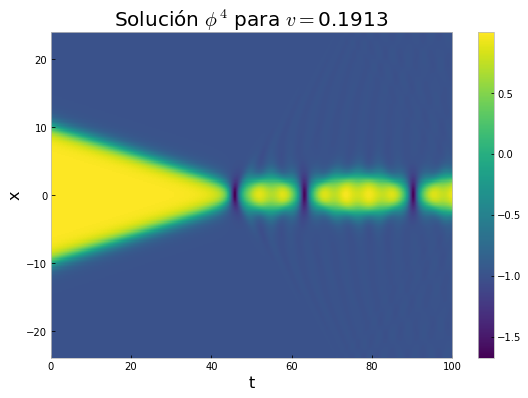

In [152]:
v_prueba = 0.19125
path_esp_c = "Charts/Spectral/Cosine"
t_prueba, x_prueba, y_prueba, bounce_prueba = solve_dct(L, dt, tend, x0, nx, v_prueba)

get_plot_phi(x_prueba, t_prueba, y_prueba, v_prueba, path_esp_c+"/calor_v_prueba")

0


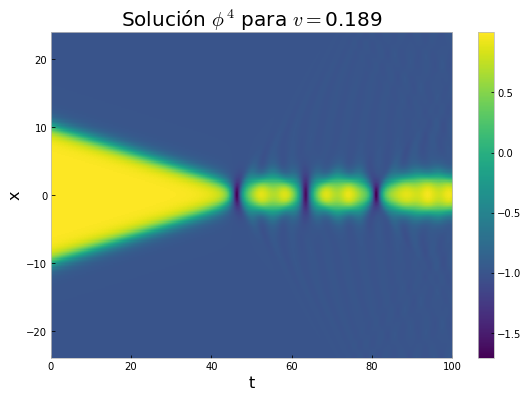

1


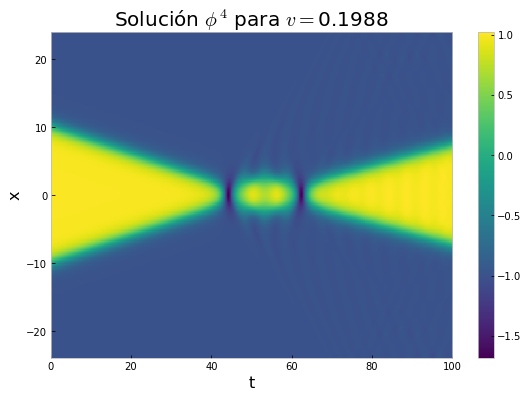

2


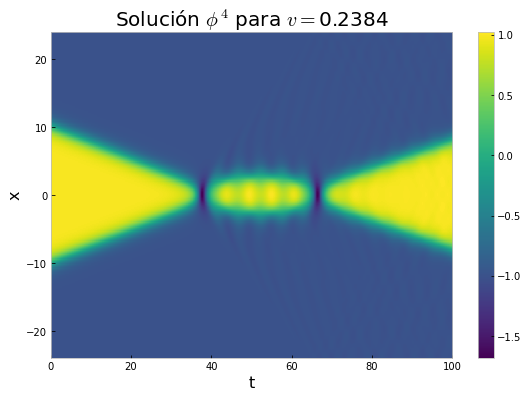

3


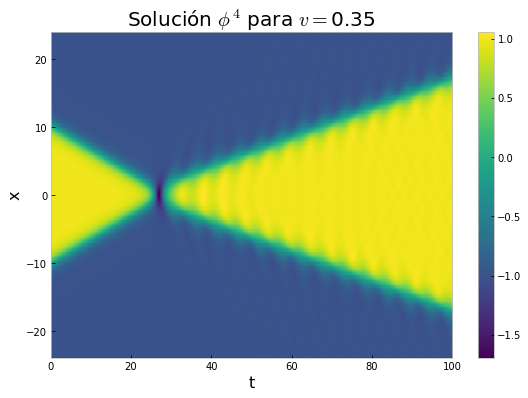

In [153]:
# Obtiene gráficos
path_esp_c = "Charts/Spectral/Cosine"

for i in range(0, len(phis)):
    print(i)
    get_plot_phi(xs[i], ts[i], phis[i], vs[i], path_esp_c+"/calor_v_{}".format(i))

MovieWriter ffmpeg unavailable; using Pillow instead.
MovieWriter ffmpeg unavailable; using Pillow instead.
MovieWriter ffmpeg unavailable; using Pillow instead.
MovieWriter ffmpeg unavailable; using Pillow instead.
MovieWriter ffmpeg unavailable; using Pillow instead.
MovieWriter ffmpeg unavailable; using Pillow instead.
MovieWriter ffmpeg unavailable; using Pillow instead.
MovieWriter ffmpeg unavailable; using Pillow instead.
MovieWriter ffmpeg unavailable; using Pillow instead.
MovieWriter ffmpeg unavailable; using Pillow instead.
MovieWriter ffmpeg unavailable; using Pillow instead.


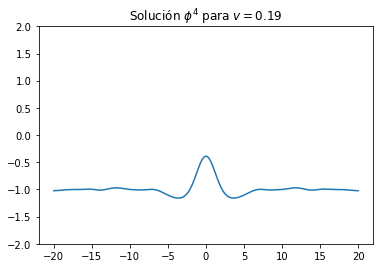

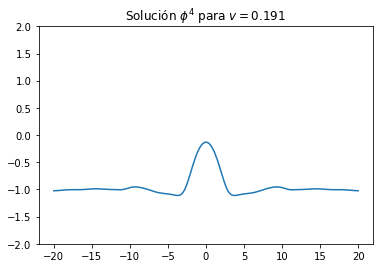

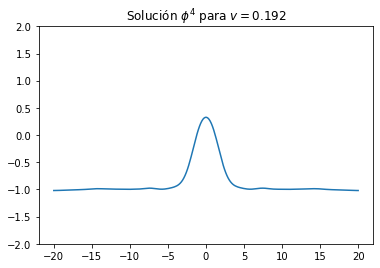

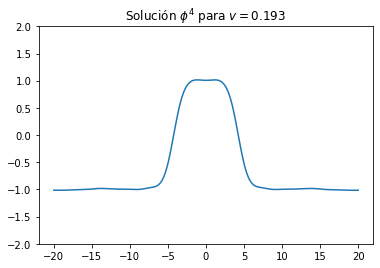

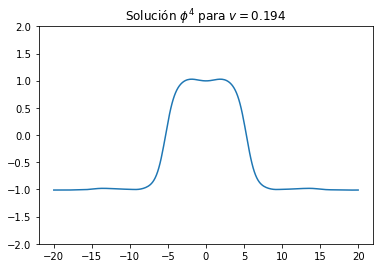

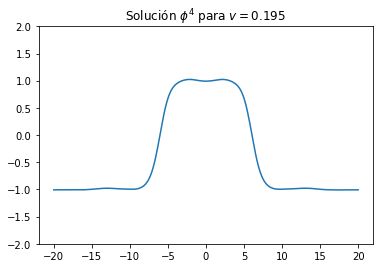

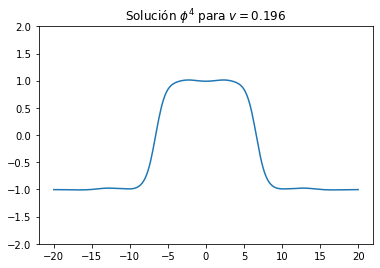

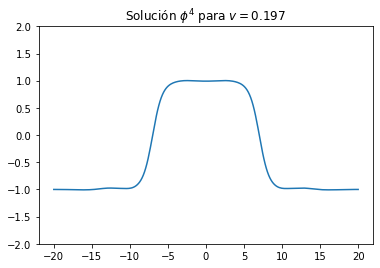

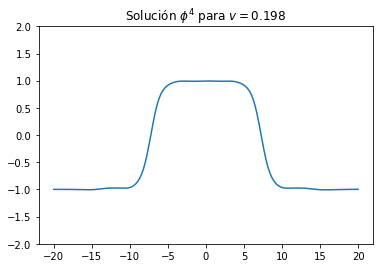

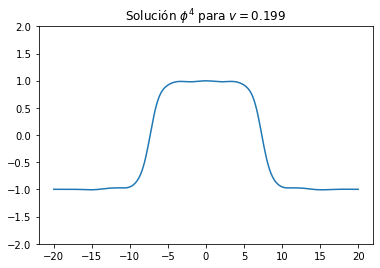

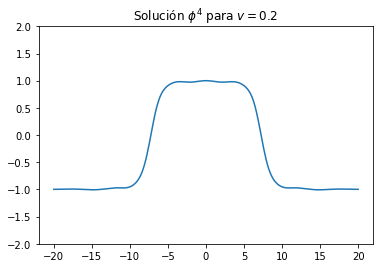

In [29]:
#for i in range(len(phis)):
#    animar_soluciones(xs[i], phis[i], vs[i], dt, tend, "Esp_c_v_{}.gif".format(i), path_esp_c)

In [164]:
energies_esp = []
dt = 1/10
h = 12/128

for phi in phis:
    energy_ = np.zeros(len(phi)-1)
    for n in range(len(phi)-1):
        E = energy(0., phi, n, dt, h)
        energy_[n] = E
    energies_esp += [energy_]

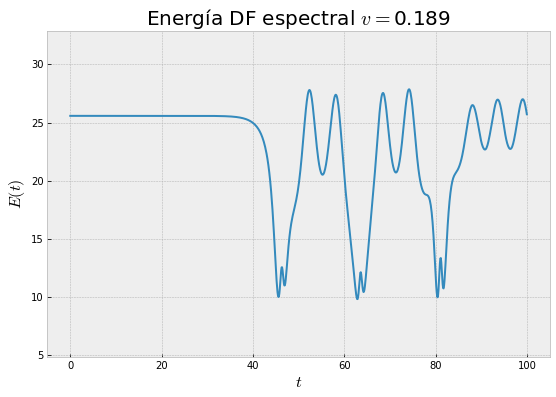

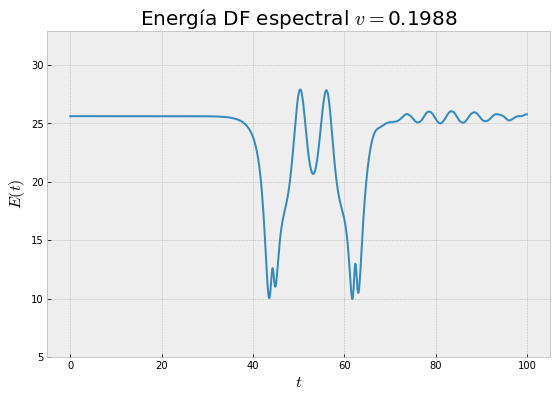

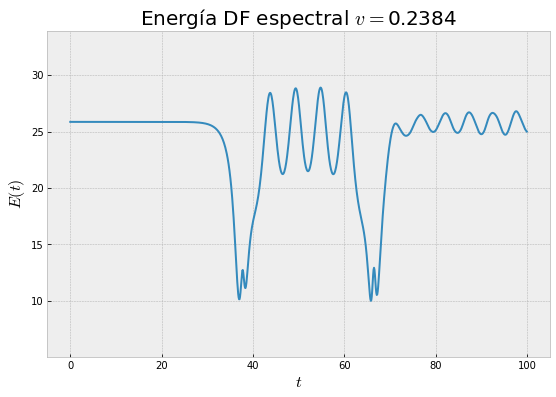

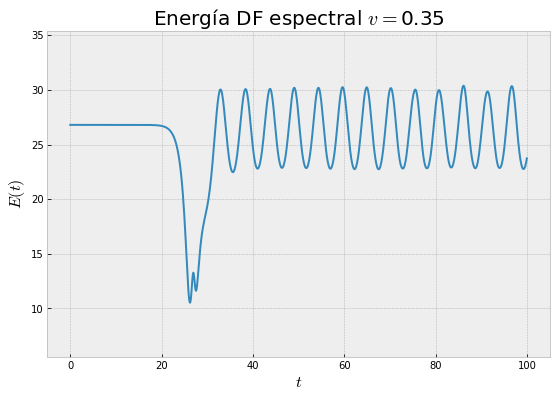

In [165]:

for i in range(len(vs)):
    plt.plot(t[:-1], energies_esp[i])
    plt.title("Energía DF espectral $v=${}".format(vs[i]))
    plt.xlabel(r"$t$")
    plt.ylabel(r"$E(t)$")
    plt.ylim(np.min(energies_esp[i])-5, np.max(energies_esp[i])+5)
    
    plt.savefig(path_esp_c + "/energia_{}.png".format(i))
    plt.show()

## Obtención velocidad de salida

La velocidad de salida se obtendrá a partir de N's de muestra que se obtengan de los bounces que tenga la solución. Es decir, se tomará una muestra de N's (temporales) tal que la solución deje de hacer bounces.

En estos casos, se tendrá que la solución avanzará con una cierta velocidad, que se calculará como sigue:
- Para cada N de muestra, se obtienen el $x_j$ de la grilla tal que la solución en ese punto sea muy cercana a 0 (en el mejor de los casos, sea cero).
- Se agrupan los $x_i$ encontrados de a pares y se calcula la velocidad entre ambos $x$.
- La velocidad final se tomará como el promedio de velocidades obtenidas.

Como la solución es par, basta realizar este proceso en uno de los lados de la grilla. Sin perdida de generalidad, usaremos el lado positivo.

In [176]:
def find_roots(x,y):
    s = np.abs(np.diff(np.sign(y))).astype(bool)
    return x[:-1][s] + np.diff(x)[s]/(np.abs(y[1:][s]/y[:-1][s])+1)

In [177]:
def get_v_out(phi, xs, bounces, n):
    n_bounce = bounces[-1]
    N_t = len(phi)
    xs_pos = xs[512//2:]

    dif = N_t - n_bounce 
    prim_n = dif//2
    zeros = []
    
    if dif < 180:
        return 0
    
    for i in range(1, prim_n):
        phi_pos = phi[-i][512//2:]
        zero = find_roots(xs_pos, phi_pos)
        if len(zero)==0:
            return 0

        zeros += [zero[0]]

    zeros = np.flip(np.array(zeros))
    v = np.mean(np.diff(zeros)/dt)
    return v

In [178]:
v_outs = []

for n in range(len(phis)):
    v = get_v_out(phis[n], xs[n], bounces[n], n)
    if v < 0:                                  
        v = 0
    v_outs += [v]

In [180]:
v_outs_copy = np.array(v_outs).copy()

In [427]:
v_outs = v_outs_copy.copy()

In [181]:
for i in range(2, len(v_outs)-2):
    if v_outs[i-1]==0 and v_outs[i+1]==0:
        v_outs[i] = 0

<function matplotlib.pyplot.show(close=None, block=None)>

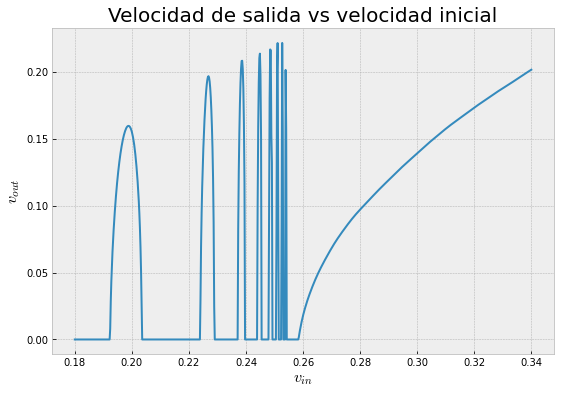

In [255]:
plt.plot(vs, v_outs)
plt.xlabel("$v_{in}$")
plt.ylabel("$v_{out}$")
plt.title("Velocidad de salida vs velocidad inicial")

plt.savefig("Charts/velocidades.png")
plt.show

### Interpolación (Deprecado)

Se utilizará una interpolación de la solución para obtener mejor precisión en la obtención de las velocidades de salida, puesto que la solución numérica no siempre cumple que se hace cero en algún punto

In [30]:
# Define una malla con los puntos usados
T, X = np.meshgrid(t_prueba, x_prueba, indexing='ij', sparse=True)

# Interpolación
y_poly = interpol((t_prueba, x_prueba), y_prueba) # Es una función

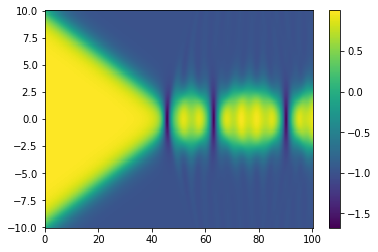

In [31]:
t_to_poly = np.linspace(0, tend, 1200)
x_to_poly = np.linspace(-L, L, 210)

T_poly, X_poly = np.meshgrid(t_to_poly, x_to_poly, indexing='ij')

#t_to_newton = np.arange(50, tend, 50)
#zeros = np.zeros(len(t_to_newton))
#for i in range(len(t_to_newton)):
#    y_poly_t = lambda x: y_poly((t_to_newton[i], x))
#    zeros[i] = newton(y_poly_t, 0, tol=1.48e-01)
    

plt.pcolormesh(T_poly, X_poly, y_poly((T_poly, X_poly)), shading="auto")
plt.colorbar()
plt.show()

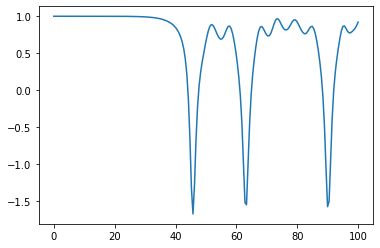

In [32]:
t_to_plot = np.linspace(0, tend, 200)
y_poly_t = lambda t: y_poly((t, 0))

plt.plot(t_to_plot, y_poly_t(t_to_plot))

### Bounces

En el esquema numérico se introdujo una variable que indica si queremos o no contar la cantidad de bounces. Esto nos permitirá encontrar los N's tal que la solución deja de rebotar (último bounce) y a partir de ese instante podemos calcular la velocidad de salida de nuestra solución.

A partir de ahora, todos los esquemas se harán con esta variable para así obtener sus respectivas $v_out$ y recrear el gráfico que necesitamos.

In [33]:
# Obtiene el número de bounces de la solución
# a partir de las veces que la solución fue menor a -1.5
def get_number_of_bounces(bounces):
    first_digit = np.vectorize(lambda s: int(str(s)[0]))(bounces)
    number_of_bounces = len(np.unique(first_digit))
    return number_of_bounces

In [34]:
for i in range(len(us)):
    pass
    #get_plot_phi(x, t, us[i], vs[i], path_imp+"/calor_v_{}".format(i))
    #print("{} Bounces".format(get_number_of_bounces(bounces[i])))